# Using TSA Passenger Throughput as Predictor of JETS ETF

## Installing & Loading Necessary Packages 


In [ ]:
install.packages("rvest") #A Web-Scrapping Package
install.packages("magrittr")
install.packages("stringr")
install.packages("quantmod")
install.packages("RMySQL")

library(rvest)
library(magrittr)
library(stringr)
library(quantmod)
library(RMySQL)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: DBI



## Scarpping TSA Passenger Throughput

In [ ]:
raw_tsa = data.frame(which_date = as.Date('1990-01-01'), num_pax = 0)
date_looped = 1

url = "https://www.tsa.gov/coronavirus/passenger-throughput"
webpage <- read_html(url)

for (n in 2:365) { 
  html_node(webpage, paste("tr:nth-child(", n ,") .views-align-center")) %>% html_text() %>% str_trim() %>% strsplit("/") -> temp_date
  for (nyear in c(2019, 2020, 2021)) {
    html_node(webpage, paste("tr:nth-child(", n ,") .views-field-field-", nyear, "-throughput", sep = "")) %>% html_text() -> temp 
    assign(paste("traffic", nyear, sep = ""), as.numeric(str_remove_all(str_trim(temp), "[,]")))
    raw_tsa[date_looped, 1] = as.Date(paste(nyear, '-', temp_date[[1]][1], '-', as.numeric(temp_date[[1]][2]), sep = ''))
    raw_tsa[date_looped, 2] = eval(parse(text = paste("traffic", nyear, sep = "")))
    date_looped = date_looped +1
  }
}

#Reorder according to date

raw_tsa<- raw_tsa[order(raw_tsa$which_date),]

#Delete Empty Rows - Part 1

for (n in 1:nrow(raw_tsa)) {
  if (is.na(raw_tsa[n ,2]) == TRUE) {
    temp = n
    break
  }
}

raw_tsa <- raw_tsa[-c(temp:nrow(raw_tsa)), ]

#Compute 7D Rolling Avg

for (m in 1:nrow(raw_tsa)) {
  raw_tsa[m+6,3] = rollmeanr(raw_tsa[,2], 7)[m]
}

#Delete Empty Rows - Part 2

for (n in 1:nrow(raw_tsa)) {
  if (is.na(raw_tsa[n ,2]) == TRUE) {
    temp = n
    break
  }
}

raw_tsa <- raw_tsa[-c(temp:nrow(raw_tsa)), ]

#Reordering Row Number According to Date

tsa = data.frame(date = as.Date("1990-01-01"), rolling_avg_7D = 0)

for (num_row in 1:nrow(raw_tsa)) {
  tsa[num_row,1] = raw_tsa[num_row,1]
  tsa[num_row,2] = raw_tsa[num_row,3]
}

In [ ]:
#Visualizing the data.frame "tsa"
tail(tsa)

,date,rolling_avg_7D
,<date>,<dbl>
869,2021-05-21,1641625
870,2021-05-22,1655450
871,2021-05-23,1657331
872,2021-05-24,1659161
873,2021-05-25,1668136
874,2021-05-26,1685576


## Downloading JETS ETF Data

In [ ]:
getSymbols("JETS")
ticker = JETS[,-c(1:5)]
colnames(ticker)[1] = "price"

adj_JETS = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(ticker)) {
  adj_JETS[num_row,1] = index(ticker)[num_row]
  adj_JETS[num_row,2] = ticker[num_row,1]
}

tail(adj_JETS)

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] "JETS"

,date,price
,<date>,<dbl>
1526,2021-05-20,26.03
1527,2021-05-21,25.94
1528,2021-05-24,26.31
1529,2021-05-25,26.21
1530,2021-05-26,26.78
1531,2021-05-27,27.07


## Downloading S&P 500 Data

In [ ]:
getSymbols("^GSPC")

SPX = GSPC[,-c(1:5)]
colnames(SPX)[1] = "price"

adj_SPX = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(SPX)) {
  adj_SPX[num_row,1] = index(SPX)[num_row]
  adj_SPX[num_row,2] = SPX[num_row,1]
}

tail(adj_SPX)

[1] "^GSPC"

,date,price
,<date>,<dbl>
3621,2021-05-20,4159.12
3622,2021-05-21,4155.86
3623,2021-05-24,4197.05
3624,2021-05-25,4188.13
3625,2021-05-26,4195.99
3626,2021-05-27,4200.88


## Downloading Risk-Free Rate (10Y US Govn't Treasuries Yield)

In [ ]:
getSymbols("DGS10", src = "FRED")

rf = data.frame(date = as.Date("1990-01-01"), yield = 0)


for (num_row in 1:nrow(DGS10)) {
  rf[num_row,1] = index(DGS10)[num_row]
  rf[num_row,2] = DGS10[num_row,1]
}

#Linearly Interpolating Missing Value
  
for (num_row in 2:nrow(rf)) {
  if (is.na(rf[num_row,2]) == TRUE) {
    rf[num_row,2] = (rf[num_row-1,2] + rf[num_row+1,2])/2
  }
}

head(rf)

[1] "DGS10"

,date,yield
,<date>,<dbl>
1,1962-01-02,4.06
2,1962-01-03,4.03
3,1962-01-04,3.99
4,1962-01-05,4.02
5,1962-01-08,4.03
6,1962-01-09,4.05


## Merging Daily JETS ETF Data & TSA Data 

In [ ]:
merge(adj_JETS, tsa, by = "date", all.x = TRUE) %>% merge(adj_SPX, by = "date", all.x = TRUE) %>% merge(rf, by = "date", all.x = TRUE) -> regression_data

colnames(regression_data)[c(2,4)] = c("JETS_price", "SPX")

tail(regression_data)

,date,JETS_price,rolling_avg_7D,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1526,2021-05-20,26.03,1626786,4159.12,1.63
1527,2021-05-21,25.94,1641625,4155.86,1.63
1528,2021-05-24,26.31,1659161,4197.05,1.61
1529,2021-05-25,26.21,1668136,4188.13,1.56
1530,2021-05-26,26.78,1685576,4195.99,1.58
1531,2021-05-27,27.07,NA,4200.88,NA


### Data Cleaning & Processing

In [ ]:
#Delete Empty Rows - 1

for (n in 1:nrow(regression_data)) {
  if (is.na(regression_data[n ,3]) == FALSE) {
    temp = n
    break
  }
}

regression_data = regression_data[-c(1:(temp-1)),]

#Delete Empty Rows - 2

for (k in nrow(regression_data):1) {
  if (is.na(regression_data[k ,3]) == FALSE) {
    temp = k
    break
  }
}

regression_data = regression_data[-c((k+1):nrow(regression_data)),]

#Linearly Interpolating Missing TSA Rolling Avg
  
for (g in 2:nrow(regression_data)) {
  if (is.na(regression_data[g,3]) == TRUE) {
    regression_data[g,3] = (regression_data[g-1,3] + regression_data[g+1,3])/2
  }
}

tail(regression_data)

,date,JETS_price,rolling_avg_7D,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1525,2021-05-19,26.27,1628932,4115.68,1.68
1526,2021-05-20,26.03,1626786,4159.12,1.63
1527,2021-05-21,25.94,1641625,4155.86,1.63
1528,2021-05-24,26.31,1659161,4197.05,1.61
1529,2021-05-25,26.21,1668136,4188.13,1.56
1530,2021-05-26,26.78,1685576,4195.99,1.58


## Transform Daily Data into Weekly Data

In [ ]:
as.xts(regression_data$JETS_price, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") -> temp_JETS
temp_JETS <- temp_JETS["2019-12-23/2021"]

as.xts(regression_data$SPX, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") -> temp_SPX
temp_SPX <- temp_SPX["2019-12-23/2021"]

as.xts(regression_data$yield, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") -> temp_yield
temp_yield <- temp_yield["2019-12-23/2021"]

as.xts(regression_data$rolling_avg_7D, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") -> temp_TSA
temp_TSA <- temp_TSA["2019-12-23/2021"]

#aggregate(x = regression_data$rolling_avg_7D, by = list(as.Date(cut(regression_data$date, "week"))), sum) -> temp_TSA
#temp_TSA = as.xts(temp_TSA[,2], order.by = as.Date(temp_TSA[,1]))
#temp_TSA <- temp_TSA["2019-12-23/2021"]

regression_data_weekly = data.frame(date = as.Date("1990-01-01"), JETS_closing_price = 0, TSA_total = 0, SPX = 0, yield = 0)

for (i in 1:nrow(temp_TSA)) {
  regression_data_weekly[i,1] = index(temp_TSA)[i]  
  regression_data_weekly[i,2] = temp_JETS[i,4]
  regression_data_weekly[i,3] = temp_TSA[i,1]
  regression_data_weekly[i,4] = temp_SPX[i,1]
  regression_data_weekly[i,5] = temp_yield[i,1]
}

if (Sys.Date() >= regression_data_weekly[nrow(temp_TSA),1]) {
  regression_data_weekly <- regression_data_weekly[-nrow(temp_TSA),]
}

head(regression_data_weekly,200)

#Consider trying 2020-04-06

,date,JETS_closing_price,TSA_total,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-12-23,31.60126,2356579.00,3224.01,1.93
2,2019-12-30,31.15744,2403582.00,3221.29,1.90
3,2020-01-06,31.34636,2162436.14,3246.28,1.81
4,2020-01-13,32.23700,1934166.14,3288.13,1.85
5,2020-01-21,31.26839,2028592.57,3320.79,1.78
6,2020-01-27,29.82797,1921779.86,3243.63,1.61
7,2020-02-03,30.79758,1918277.00,3248.92,1.54
8,2020-02-10,31.32137,2064549.71,3352.09,1.56
9,2020-02-18,30.42973,2264584.00,3370.29,1.55


## Export data.frame into SQL DB

In [ ]:
queryMySQL = function(statement) {
  con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7")
  response = dbGetQuery(con,statement)
  dbDisconnect(con)

  return(response)  
}

queryMySQL("show tables in writeable_fina_4359_u3548379")

#lapply(dbListConnections(dbDriver( drv = "MySQL")), dbDisconnect)

Tables_in_writeable_fina_4359_u3548379
<chr>
Boxoffice_weekly_revenue
JETS
TSA
alexarank_daily_by_individual_companies
alexarank_daily_cummulative
alexarank_weekly_cummulative
google_trends_weekly_data
visits


In [ ]:
con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7", dbname = "writeable_fina_4359_u3548379")
dbWriteTable(conn = con, name = "TSA", regression_data_weekly[,c(1,3)], overwrite = TRUE) 
dbWriteTable(conn = con, name = "JETS", regression_data_weekly[,c(1,2,4:5)], overwrite = TRUE) 

queryMySQL("select * from writeable_fina_4359_u3548379.TSA order by date asc limit 10")
queryMySQL("select * from writeable_fina_4359_u3548379.JETS order by date asc limit 10")

[1] TRUE

[1] TRUE

row_names,date,TSA_total
<chr>,<chr>,<dbl>
1,2019-12-23,2356579
2,2019-12-30,2403582
3,2020-01-06,2162436
4,2020-01-13,1934166
5,2020-01-21,2028593
6,2020-01-27,1921780
7,2020-02-03,1918277
8,2020-02-10,2064550
9,2020-02-18,2264584


row_names,date,JETS_closing_price,SPX,yield
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,2019-12-23,31.60126,3224.01,1.93
2,2019-12-30,31.15744,3221.29,1.90
3,2020-01-06,31.34636,3246.28,1.81
4,2020-01-13,32.23700,3288.13,1.85
5,2020-01-21,31.26839,3320.79,1.78
6,2020-01-27,29.82797,3243.63,1.61
7,2020-02-03,30.79758,3248.92,1.54
8,2020-02-10,31.32137,3352.09,1.56
9,2020-02-18,30.42973,3370.29,1.55


## Prepare Data for Regression

,date,JETS_weekly_return,TSA_weekly_change,SPX_weekly_return,JETS_weekly_excess_return,SPX_weekly_excess_return,JETS_rebased,TSA_rebased,SPX_rebased
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-12-23,NA,NA,NA,NA,NA,1.0000000,1.00000000,1.0000000
2,2019-12-30,-0.014044472,0.019945438,-0.0008436608,-0.014409857,-0.001209045,0.9859555,1.01994544,0.9991563
3,2020-01-06,0.006063496,-0.100327701,0.0077577584,0.005715419,0.007409682,0.9919339,0.91761666,1.0069076
4,2020-01-13,0.028412997,-0.105561499,0.0128916340,0.028057228,0.012535865,1.0201177,0.82075167,1.0198882
5,2020-01-21,-0.030046528,0.048820226,0.0099327451,-0.030388835,0.009590437,0.9894667,0.86082095,1.0300185
6,2020-01-27,-0.046066358,-0.052653606,-0.0232354816,-0.046375974,-0.023545097,0.9438856,0.81549562,1.0060855
7,2020-02-03,0.032506702,-0.001822715,0.0016309009,0.032210548,0.001334747,0.9745682,0.81400921,1.0077264
8,2020-02-10,0.017007505,0.076252134,0.0317552197,0.016707505,0.031455220,0.9911431,0.87607914,1.0397269
9,2020-02-18,-0.028467528,0.096890031,0.0054294337,-0.028765605,0.005131357,0.9629277,0.96096248,1.0453721


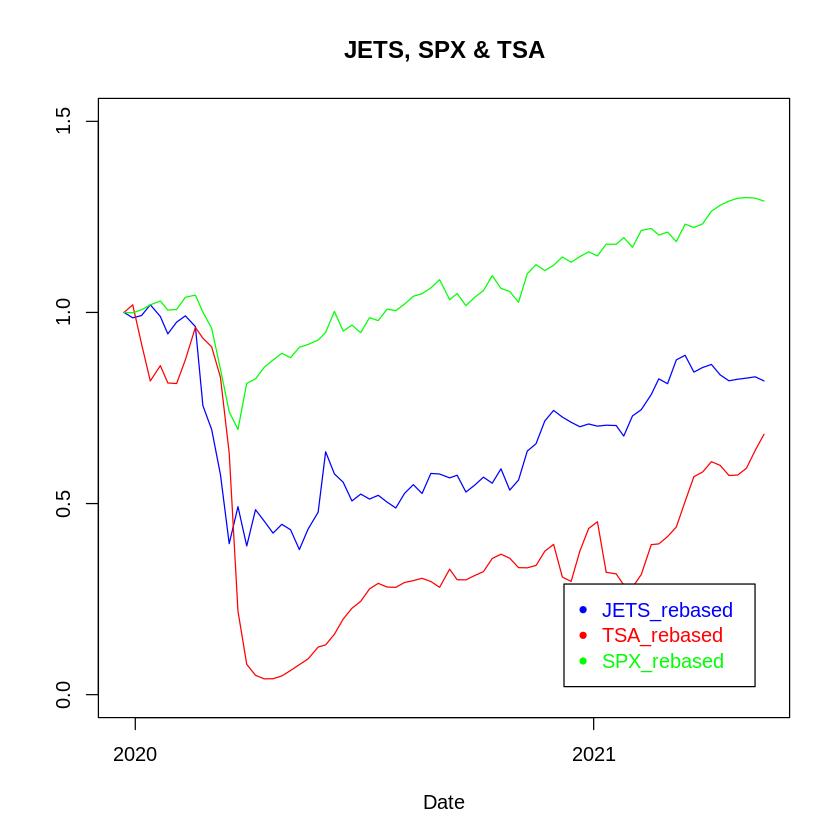

In [ ]:
to_regress = queryMySQL("select a.date,
                        (a.temp_JETS - 1) as JETS_weekly_return,
                        (a.temp_TSA - 1) as TSA_weekly_change,
                        (a.temp_SPX - 1) as SPX_weekly_return,
                        ((a.temp_JETS - 1) - a.yield/52/100) as JETS_weekly_excess_return,
                        ((a.temp_SPX - 1) - a.yield/52/100) as SPX_weekly_excess_return
                        from (select j.date, j.yield, 
                        t.TSA_total/lag(t.TSA_total, 1) OVER (ORDER BY date ASC) as temp_TSA,
                        j.JETS_closing_price/lag(j.JETS_closing_price, 1) OVER (ORDER BY date ASC) as temp_JETS,
                        j.SPX/lag(j.SPX, 1) OVER (ORDER BY date ASC) as temp_SPX
                        from writeable_fina_4359_u3548379.TSA as t 
                        left join writeable_fina_4359_u3548379.JETS as j on t.date = j.date
                        order by j.date) as a")

for (i in 1:nrow(to_regress)) {
    if (i == 1) {
      to_regress[i,7] = 1
      to_regress[i,8] = 1
      to_regress[i,9] = 1
    } else {
      to_regress[i,7] = to_regress[i-1,7] * (1 + to_regress[i,2])
      to_regress[i,8] = to_regress[i-1,8] * (1 + to_regress[i,3])
      to_regress[i,9] = to_regress[i-1,9] * (1 + to_regress[i,4])
    }
}

to_regress[,1] <- as.Date(to_regress[,1])
colnames(to_regress)[7:9] = c("JETS_rebased", "TSA_rebased", "SPX_rebased")

tail(to_regress,100)

plot(x = to_regress[,1], y = to_regress[,7], type = "l", col = "blue", ylim = c(0,1.5), xlab = "Date", ylab = "", main = "JETS, SPX & TSA")
lines(x = to_regress[,1], y = to_regress[,8], type = "l", col = "red")
lines(x = to_regress[,1], y = to_regress[,9], type = "l", col = "green")
legend("bottomright", 
        legend = colnames(to_regress)[7:9], 
        col = c("blue", "red", "green"),  
        pch = 20, 
        bty = "o", 
        pt.cex = 1, 
        cex = 1, 
        text.col = c("blue", "red", "green"), 
        inset = c(0.05, 0.05))

## Regressing Arithmetic Weekly JETS Return - CAPM


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27326 -0.03856 -0.00087  0.03462  0.32410 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.0004185  0.0112309   0.037    0.970
to_regress[, 6] 0.3152658  0.2949290   1.069    0.289

Residual standard error: 0.09473 on 70 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.01606,	Adjusted R-squared:  0.002005 
F-statistic: 1.143 on 1 and 70 DF,  p-value: 0.2888


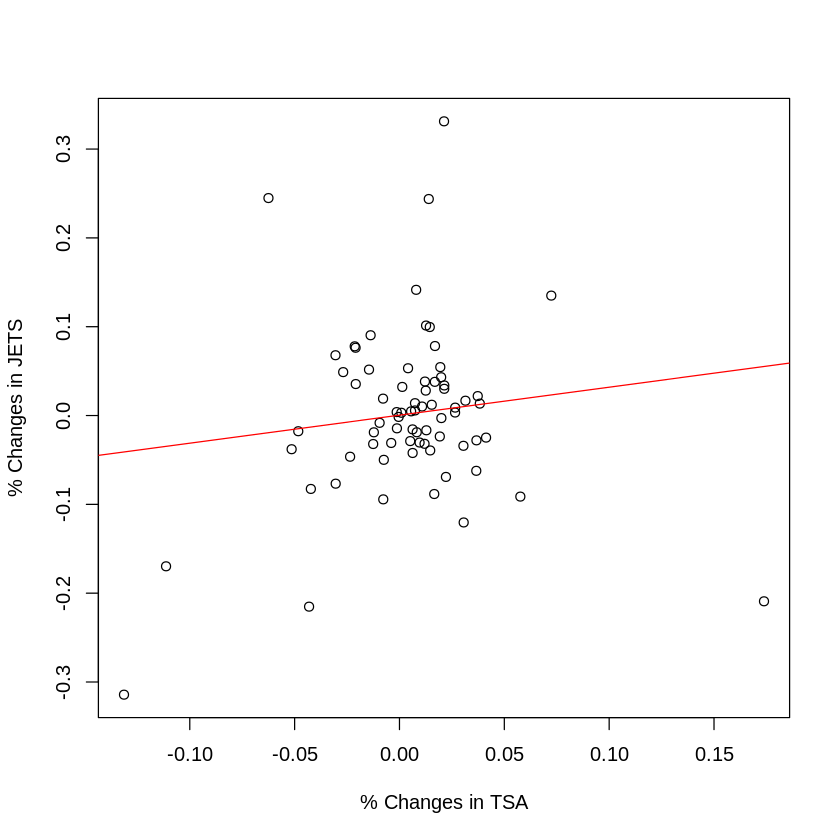

In [ ]:
lm_result_1 = lm(to_regress[,5] ~ to_regress[,6]) # i.e. CAPM
summary(lm_result_1)

plot(to_regress[,5] ~ to_regress[,6], xlab = "% Changes in Market", ylab = "% Changes in JETS")
abline(lm_result_1, col="red")

## Regressing Arithmetic Weekly JETS Return - TSA

In [ ]:
lm_result_2 = lm(to_regress[,5] ~ to_regress[,3])
summary(lm_result_2)

plot(to_regress[,5] ~ to_regress[,3], xlab = "% Changes in TSA", ylab = "% Changes in JETS")
abline(lm_result_2, col="red")


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 3])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31208 -0.03585  0.00113  0.03592  0.32872 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.001529   0.011284   0.135    0.893
to_regress[, 3] 0.015464   0.067245   0.230    0.819

Residual standard error: 0.09546 on 70 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.000755,	Adjusted R-squared:  -0.01352 
F-statistic: 0.05289 on 1 and 70 DF,  p-value: 0.8188


## Regressing Arithmetic Weekly JETS Return - "Improved CAPM with TSA"

In [ ]:
lm_result_3 = lm(to_regress[,5] ~ to_regress[,6] + to_regress[,3]) 
summary(lm_result_3)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6] + to_regress[, 
    3])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26786 -0.03868 -0.00098  0.03407  0.32308 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.0001535  0.0113438   0.014    0.989
to_regress[, 6] 0.3195152  0.2972617   1.075    0.286
to_regress[, 3] 0.0191027  0.0672555   0.284    0.777

Residual standard error: 0.09536 on 69 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.01721,	Adjusted R-squared:  -0.01128 
F-statistic: 0.6042 on 2 and 69 DF,  p-value: 0.5494


## Clickhouse


In [1]:
install.packages("RClickhouse")
install.packages("DBI")

library(RClickhouse)
library(DBI)

queryClickhouse = function(statement) {
  con <- dbConnect(RClickhouse::clickhouse(), host="147.8.113.184", user = "alpha_generators", password = "alternativedata")
  response = dbGetQuery(con,statement)
  dbDisconnect(con)

  return(response)  
}

queryClickhouse("show tables in safegraph")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bit’, ‘bit64’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,name
,<chr>
1,brands
2,matched_sod
3,poi
4,social_distancing
5,weekly_pattern_home_summary_file
6,weekly_patterns
7,weekly_patterns_normalization


In [2]:
queryClickhouse("select date_range_start, raw_visit_counts from safegraph.weekly_patterns where location_name = 'Topgolf' order by date_range_start")
queryClickhouse("select * from safegraph.weekly_patterns where location_name = 'AMC Entertainment' order by date_range_start limit 10")

,date_range_start,raw_visit_counts
,<chr>,<int>
1,2018-12-31T00:00:00-05:00,397
2,2018-12-31T00:00:00-05:00,770
3,2018-12-31T00:00:00-05:00,1851
4,2018-12-31T00:00:00-05:00,645
5,2018-12-31T00:00:00-05:00,65
6,2018-12-31T00:00:00-05:00,10
7,2018-12-31T00:00:00-05:00,2
8,2018-12-31T00:00:00-05:00,31
9,2018-12-31T00:00:00-05:00,2


,safegraph_place_id,location_name,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_week_brand,device_type
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,sg:cc1b34b06d5946ee9a3282d95c8e851f,AMC Entertainment,2018-12-31T00:00:00-05:00,2019-01-07T00:00:00-05:00,57,56,"[4,12,1,6,9,18,7]","[0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,1,2,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,2,0,2,2,0,1,1,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,2,1,0,1,0]",360290092003,"{""""360290093013"""":4,""""360630227121"""":4,""""360290005002"""":4,""""360630243011"""":4,""""360630228031"""":4,""""360290024002"""":4,""""360290047002"""":4,""""360290113001"""":4,""""360290090102"""":4,""""360290091092"""":4,""""360630226011"""":4,""""360630234021"""":4,""""360290080035"""":4,""""360630236002"""":4}","{""""360290080035"""":4,""""360290100012"""":4,""""360290172001"""":4,""""360630222002"""":4,""""360290005002"""":4,""""360290038003"""":4,""""360290083002"""":4,""""360630227121"""":4,""""360630226011"""":4,""""360290090073"""":4}","{""""US"""":58}",8536,117,"{""""<5"""":1,""""5-20"""":5,""""21-60"""":4,""""61-240"""":47,"""">240"""":0}","{""""Volkswagen"""":100,""""AutoZone"""":14,""""Kohl's"""":14,""""Subway"""":13,""""Dick's Sporting Goods"""":11,""""7-Eleven"""":10,""""Goodwill Industries"""":8,""""Target"""":7,""""Walmart"""":6}","{""""Tim Hortons"""":23,""""Wegmans Food Markets"""":18,""""Tops Friendly Markets"""":11,""""Goodwill Industries"""":9,""""Dick's Sporting Goods"""":7,""""ALDI"""":6,""""Marathon"""":6,""""Panera Bread"""":6,""""Sunoco"""":6,""""GameStop"""":6,""""Mighty Taco"""":5}","{""""android"""":49,""""ios"""":6}"
2,sg:3f654bf86cd247acb50f99642a4d8d6e,AMC Entertainment,2018-12-31T00:00:00-05:00,2019-01-07T00:00:00-05:00,1245,1084,"[134,184,144,181,258,219,125]","[0,0,0,0,0,0,0,0,0,11,3,4,13,17,4,10,17,5,3,45,1,1,0,0,0,0,0,0,0,0,0,0,0,3,3,4,17,24,8,18,32,4,7,53,3,3,5,0,0,0,0,0,0,0,0,0,1,5,1,2,13,17,5,6,26,6,4,52,0,1,4,1,0,0,0,0,0,0,0,0,0,3,4,2,14,15,5,19,23,6,6,63,3,12,5,1,0,0,0,0,0,0,0,0,0,3,7,5,14,23,3,17,21,9,13,102,18,17,6,0,0,0,0,0,0,0,0,0,0,5,10,3,14,19,3,18,34,7,8,79,9,6,4,0,1,0,0,0,0,0,0,0,0,3,10,0,5,11,2,17,15,5,6,43,6,1,0,0]",131171306131,"{""""131171303022"""":35,""""131171303042"""":26,""""131171305082"""":24,""""131171304051"""":24,""""131171306132"""":23,""""131171305102"""":22,""""131171306123"""":22,""""131171306031"""":20,""""131171303012"""":20,""""131171303072"""":20,""""131171305101"""":19,""""131171306073"""":19,""""131171303023"""":18,""""131171303071"""":17,""""131171303061"""":17,""""131171306052"""":17,""""131171306091"""":16,""""131171304041"""":14,""""131171303053"""":14,""""131171303021"""":14,""""131171305081"""":13,""""131171306112"""":13,""""131171306062"""":12,""""131171302041"""":12,""""131171302031"""":11,""""131171306071"""":11,""""131171306051"""":10,""""131171303041"""":10,""""131171305103"""":10,""""131171301011"""":10,""""131171304034"""":10,""""131171302011"""":9,""""131171306041"""":8,""""131171306102"""":8,""""131171306093"""":8,""""131171303052"""":7,""""131171306022"""":7,""""131171305032"""":7,""""131171304062"""":7,""""131171302023"""":7,""""131171304042"""":7,""""131171302021"""":7,""""131171305031"""":7,""""131350501081"""":7,""""131171306101"""":7,""""131171301041"""":7,""""131171304063"""":7,""""131171306092"""":7,""""131171301021"""":6,""""131171303011"""":6,""""131171302013"""":6,""""131171306122"""":6,""""131171303062"""":6,""""131171303031"""":6,""""131171304061"""":6,""""131171306111"""":5,""""131210116251"""":5,""""131171306131""""

,safegraph_place_id,location_name,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_week_brand,device_type
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,sg:cc1b34b06d5946ee9a3282d95c8e851f,AMC Entertainment,2018-12-31T00:00:00-05:00,2019-01-07T00:00:00-05:00,57,56,"[4,12,1,6,9,18,7]","[0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,1,2,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,2,0,2,2,0,1,1,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,2,1,0,1,0]",360290092003,"{""""360290093013"""":4,""""360630227121"""":4,""""360290005002"""":4,""""360630243011"""":4,""""360630228031"""":4,""""360290024002"""":4,""""360290047002"""":4,""""360290113001"""":4,""""360290090102"""":4,""""360290091092"""":4,""""360630226011"""":4,""""360630234021"""":4,""""360290080035"""":4,""""360630236002"""":4}","{""""360290080035"""":4,""""360290100012"""":4,""""360290172001"""":4,""""360630222002"""":4,""""360290005002"""":4,""""360290038003"""":4,""""360290083002"""":4,""""360630227121"""":4,""""360630226011"""":4,""""360290090073"""":4}","{""""US"""":58}",8536,117,"{""""<5"""":1,""""5-20"""":5,""""21-60"""":4,""""61-240"""":47,"""">240"""":0}","{""""Volkswagen"""":100,""""AutoZone"""":14,""""Kohl's"""":14,""""Subway"""":13,""""Dick's Sporting Goods"""":11,""""7-Eleven"""":10,""""Goodwill Industries"""":8,""""Target"""":7,""""Walmart"""":6}","{""""Tim Hortons"""":23,""""Wegmans Food Markets"""":18,""""Tops Friendly Markets"""":11,""""Goodwill Industries"""":9,""""Dick's Sporting Goods"""":7,""""ALDI"""":6,""""Marathon"""":6,""""Panera Bread"""":6,""""Sunoco"""":6,""""GameStop"""":6,""""Mighty Taco"""":5}","{""""android"""":49,""""ios"""":6}"
2,sg:3f654bf86cd247acb50f99642a4d8d6e,AMC Entertainment,2018-12-31T00:00:00-05:00,2019-01-07T00:00:00-05:00,1245,1084,"[134,184,144,181,258,219,125]","[0,0,0,0,0,0,0,0,0,11,3,4,13,17,4,10,17,5,3,45,1,1,0,0,0,0,0,0,0,0,0,0,0,3,3,4,17,24,8,18,32,4,7,53,3,3,5,0,0,0,0,0,0,0,0,0,1,5,1,2,13,17,5,6,26,6,4,52,0,1,4,1,0,0,0,0,0,0,0,0,0,3,4,2,14,15,5,19,23,6,6,63,3,12,5,1,0,0,0,0,0,0,0,0,0,3,7,5,14,23,3,17,21,9,13,102,18,17,6,0,0,0,0,0,0,0,0,0,0,5,10,3,14,19,3,18,34,7,8,79,9,6,4,0,1,0,0,0,0,0,0,0,0,3,10,0,5,11,2,17,15,5,6,43,6,1,0,0]",131171306131,"{""""131171303022"""":35,""""131171303042"""":26,""""131171305082"""":24,""""131171304051"""":24,""""131171306132"""":23,""""131171305102"""":22,""""131171306123"""":22,""""131171306031"""":20,""""131171303012"""":20,""""131171303072"""":20,""""131171305101"""":19,""""131171306073"""":19,""""131171303023"""":18,""""131171303071"""":17,""""131171303061"""":17,""""131171306052"""":17,""""131171306091"""":16,""""131171304041"""":14,""""131171303053"""":14,""""131171303021"""":14,""""131171305081"""":13,""""131171306112"""":13,""""131171306062"""":12,""""131171302041"""":12,""""131171302031"""":11,""""131171306071"""":11,""""131171306051"""":10,""""131171303041"""":10,""""131171305103"""":10,""""131171301011"""":10,""""131171304034"""":10,""""131171302011"""":9,""""131171306041"""":8,""""131171306102"""":8,""""131171306093"""":8,""""131171303052"""":7,""""131171306022"""":7,""""131171305032"""":7,""""131171304062"""":7,""""131171302023"""":7,""""131171304042"""":7,""""131171302021"""":7,""""131171305031"""":7,""""131350501081"""":7,""""131171306101"""":7,""""131171301041"""":7,""""131171304063"""":7,""""131171306092"""":7,""""131171301021"""":6,""""131171303011"""":6,""""131171302013"""":6,""""131171306122"""":6,""""131171303062"""":6,""""131171303031"""":6,""""131171304061"""":6,""""131171306111"""":5,""""131210116251"""":5,""""131171306131""""